In [1]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import igraph
import platform
import json
from ast import literal_eval as make_tuple
import matplotlib.cm as cm
import utils

/Users/jarus/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/jarus/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/jarus/miniconda3/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
# libraries for gromov distance computation.
import numpy as np
import scipy as sp
import ot
from sklearn.decomposition import PCA
from sklearn import manifold

In [3]:
#from actions.groupBy import groupBy
from state import State
from preprocess import PreProcess

In [4]:
%matplotlib inline

In [5]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

# Change the directory name according to your system

In [6]:
dirname = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow"
# dirname = "/home/vidi/Work/llnl/CallFlow/.callflow"

## Load the datasets and create Dataframes

In [7]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [8]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

#     state.map = state.node_hash_mapper()

    # Print the module group by information. 
    # print(state.df.groupby(['module']).agg(['mean','count']))

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)

    return state

In [9]:
datasets = ["kripke-impi", "kripke-mvapich2", "kripke-openmpi"]
states = {}
for idx, dataset_name in enumerate(datasets):
    state = read_gf(dataset_name)
    states[dataset_name] = state
print(states)

{'kripke-impi': <state.State object at 0x1a21dd4b00>, 'kripke-mvapich2': <state.State object at 0x1a21dc3a58>, 'kripke-openmpi': <state.State object at 0x1a2236dd68>}


In [10]:
def lookup_with_name(df, name):
    return df.loc[df['name'] == name]

In [11]:
def add_paths(state, path_name):
    for idx, row in state.df.iterrows():
        if row.show_node:
            path = row[path_name]
            if isinstance(path, str):
                path = make_tuple(row[path_name])
            state.g.add_path(path)   

In [12]:
def generic_map(df, nodes, attr):
    ret = {}
    for node in nodes: 
        if attr == 'time (inc)':
            ret[node] = df[df['name'] == node][attr].mean()
        else:
            ret[node] = df[df['name'] == node][attr].unique().tolist()     
    return ret

In [13]:
def calculate_flows(state):
    graph = state.g
    ret = {}                                                                                                                                                                                                                                                                          
    edges = graph.edges()                                                                                                                                                                                                                                                             
    additional_flow = {}                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                          
    # Calculates the costs in cycles and aggregates to one node.                                                                                                                                                                                                                      
    for edge in edges:                                                                                                                                                                                                                                                                
        source = edge[0]                                                                                                                                                                                                                                                              
        target = edge[1]                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                
    for edge in edges:                                                                                                                                                                                                                                                                
        added_flow = 0                                                                                                                                                                                                                                                                
        if edge[0].endswith('_'):                                                                                                                                                                                                                                                     
            ret[edge] = additional_flow[edge[0]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        elif edge[1].endswith('_'):                                                                                                                                                                                                                                                   
            ret[edge] = additional_flow[edge[1]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        source = lookup_with_name(state.df, edge[0])                                                                                                                                                                                                                         
        target = lookup_with_name(state.df, edge[1])                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                          
        source_inc = source['time (inc)'].max()                                                                                                                                                                                                                               
        target_inc = target['time (inc)'].max()                                                                         
                                                                                                                                                                                                                                                                                          
        if source_inc == target_inc:                                                                                                                                                                                                                                                  
            ret[edge] = source_inc                                                                                                                                                                                                                                                    
        else:                                                                                                                                                                                                                                                                         
            ret[edge] = target_inc    
    return ret   

In [14]:
def add_edge_attributes(state):
    capacity_mapping = calculate_flows(state)    
    nx.set_edge_attributes(state.g, name='weight', values=capacity_mapping)

In [15]:
def add_node_attributes(state):
    module_mapping = generic_map(state.df, state.g.nodes(), 'module')
    nx.set_node_attributes(state.g, name='module', values=module_mapping)
    
    time_mapping = generic_map(state.df, state.g.nodes(), 'time (inc)')
    nx.set_node_attributes(state.g, name='time (inc)', values=time_mapping)

In [18]:
def create_nx_graph(states):
    for idx, state_name in enumerate(states):
        state = states[state_name]
        state.g = nx.DiGraph()
        root_df = lookup_with_name(state.df, state.graph.roots[0].callpath[-1])
        state.root = root_df['name'].tolist()[0]
        state.rootInc = root_df['time (inc)'].max()
        add_paths(state, 'path')
#         state.levelMap = add_levels(state)
        add_node_attributes(state)
        add_edge_attributes(state)  
    return states

In [19]:
states = create_nx_graph(states)
print(states)

{'kripke-impi': <state.State object at 0x1a21dd4b00>, 'kripke-mvapich2': <state.State object at 0x1a21dc3a58>, 'kripke-openmpi': <state.State object at 0x1a2236dd68>}


In [22]:
# dataset = 'kripke-openmpi'
# dataset = 'kripke-impi'
dataset = 'kripke-mvapich2'

In [36]:
modules = states[dataset].entire_df['module'].unique()
print(modules)
df_modules = states[dataset].df['module'].unique()
print(df_modules)
for module in modules:
    print('Module:', module)
    print(states[dataset].entire_df.loc[states[dataset].entire_df['module'] == module][['name','time (inc)', 'time']])

['<unknown load module>' 'Unknown(NA)' 'libmonitor.so.0.0.0' 'kripke'
 'libmpi.so.12.0.5' 'libpsm2.so.2.1' 'libstdc++.so.6.0.20' 'libc-2.17.so'
 'libm-2.17.so' 'libpthread-2.17.so' 'ld-2.17.so' 'libintlc.so.5']
['<unknown load module>' 'Unknown(NA)' 'libmonitor.so.0.0.0' 'kripke'
 'libm-2.17.so' 'libc-2.17.so' 'libstdc++.so.6.0.20' 'libmpi.so.12.0.5'
 'libpsm2.so.2.1' 'libintlc.so.5' 'ld-2.17.so' 'libpthread-2.17.so']
Module: <unknown load module>
                     name  time (inc)  time
0    <partial call paths>        0.00  0.00
1    <partial call paths>        0.00  0.00
2    <partial call paths>        0.00  0.00
3    <partial call paths>        0.00  0.00
4    <partial call paths>        0.00  0.00
..                    ...         ...   ...
251   <unknown procedure>        0.00  0.00
252   <unknown procedure>        0.00  0.00
253   <unknown procedure>        0.00  0.00
254   <unknown procedure>        0.00  0.00
255   <unknown procedure>        0.00  0.00

[256 rows x 3 colum

In [56]:
new_df = states[dataset].entire_df[states[dataset].entire_df['time (inc)'] > 0]
# states['kripke-impi'].entire_df['time (inc)'].hist(bins=5)
sorted_time_inc_df = new_df.groupby(['name']).max().sort_values('time (inc)')

In [55]:
filtered_df = sorted_time_inc_df.loc[sorted_time_inc_df['time (inc)'] > 0.0001*194595257]
print(filtered_df.shape)
print(filtered_df['module'].unique())

(249, 18)
['libmpi.so.12.0.5' 'Unknown(NA)' 'libpsm2.so.2.1' 'libc-2.17.so'
 'libstdc++.so.6.0.20' 'kripke' 'libmonitor.so.0.0.0']


In [39]:
a = new_df.pivot_table(columns='name', values='time')
print(a)

name  100:MPIDI_CH3_Request_destroy  1014:PMPI_Waitany  1048:MPIC_Isend  \
time                           0.00               0.00             0.00   

name  104:operator new(unsigned long)  1058:MPIC_Waitall  \
time                             0.00               0.00   

name  106:MPIU_Handle_obj_alloc_unsafe  \
time                              0.00   

name  107:MPIDI_CH3I_SHMEM_COLL_Barrier_gather  1081:MPIR_Reduce_MV2  \
time                                      0.00                  0.00   

name  1096:MPIR_Reduce_knomial_MV2  111:_dl_lookup_symbol_x     ...      \
time                          0.00                     0.00     ...       

name  testany.c:72  testany.c:76  testany.c:80  testany.c:82  testany.c:90  \
time      2,665.16         46.47      3,878.27      5,373.53      3,784.70   

name  testany.c:93  testany.c:95  testany.c:97  writev.c:51  wtime.c:48  
time      1,213.86      1,168.30      3,879.36     1,060.51       46.73  

[1 rows x 784 columns]


In [46]:
def find_same_values(df1, df2):
    # Write a function that returns modules which actually dont spend time. 
    return []

In [80]:
def drop(df, values):
    for value in values:
        df = df[df.name != value]
    return df

# Bland altman plot.

In [75]:
def bland_altman_plot(df1, df2, col, catcol, *args, **kwargs):
    df1 = drop(df1, ['<program root>', 'SweepSolver', 'main'])
    df2 = drop(df2, ['<program root>', 'SweepSolver', 'main'])
    print(df1['name'].unique())
    data1 = np.asarray(df1[col])
    data2 = np.asarray(df2[col])
    print(len(data1), len(data2))
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    print(md, sd)
#     categories = np.concatenate(np.unique((df1[catcol].tolist()), np.unique(df2[catcol].tolist())), axis=1)
    categories = np.unique(df1[catcol].tolist())
    colors = cm.rainbow(np.linspace(0, 1, len(categories)))
    colordict = dict(zip(categories, colors))

    print(colordict)
    df1["Color"] = df1[catcol].apply(lambda x: colordict[x])
    plt.scatter(mean, diff, c=df1.Color, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

<program root> 0.0
<unknown file> [kripke]:0 53259631.510416664
Kernel_3d_DGZ::LPlusTimes 49452833.2109375
Kernel_3d_DGZ::LTimes 50118253.21875
Kernel_3d_DGZ::scattering 76616826.7890625
Loop@<unknown file> [kripke]:0 0.0
SweepSolver 139.859375
main 0.0
<thread root> 0.0
<unknown file> [libpsm2.so.2.1]:0 31897603.0
<unknown procedure> 0x213b6 [libpsm2.so.2.1] 0.0
<unknown procedure> 0x22654 [libpsm2.so.2.1] 0.0
<unknown procedure> 0x238a3 [libpsm2.so.2.1] 0.0
<unknown procedure> 0x238d7 [libpsm2.so.2.1] 0.0
<unknown procedure> 0x23961 [libpsm2.so.2.1] 0.0
__poll_nocancel 0.0
syscall-template.S:81 147581046.0
['Loop@<unknown file> [kripke]:0' 'Kernel_3d_DGZ::LPlusTimes'
 '<unknown file> [kripke]:0' 'Kernel_3d_DGZ::LTimes'
 'Kernel_3d_DGZ::scattering']
2560 2560
-5229.940625 204009.8501432944
{'<unknown file> [kripke]:0': array([0.5, 0. , 1. , 1. ]), 'Kernel_3d_DGZ::LPlusTimes': array([0.00196078, 0.70928131, 0.92328911, 1.        ]), 'Kernel_3d_DGZ::LTimes': array([0.50392157, 0.9999810

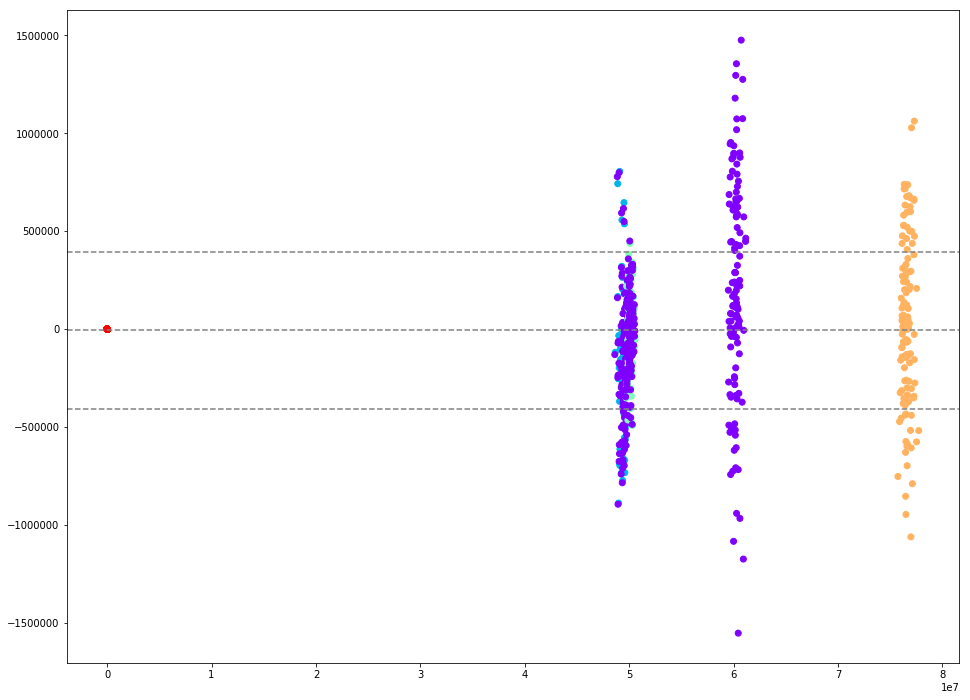

In [86]:
group_df = states['kripke-impi'].df.groupby(['name'])
for idx, g in group_df:
    print(idx, g['time'].mean())
    
group_df = states['kripke-openmpi'].df.groupby(['name'])
for idx, g in group_df:
    print(idx, g['time'].mean())
    
bland_altman_plot(states['kripke-impi'].df, states['kripke-mvapich2'].df, 'time', 'name')

## Verify topology


In [103]:
def source_target_to_adj_matrix(arr):
    key_map = {}
    x_arr = []
    for idx, elem in enumerate(arr):
        if elem['source'] not in x_arr and elem['source'] not in key_map:
            key_map[elem['source']] = len(x_arr)
            x_arr.append(elem['source'])
        if elem['target'] not in x_arr and elem['target'] not in key_map:
            key_map[elem['target']] = len(x_arr)
            x_arr.append(elem['target'])
            
    x, y = len(list(set(x_arr))), len(list(set(x_arr)))
    adj_matrix = np.zeros(shape=(x, y))
    
    for idx, elem in enumerate(arr):
        if(elem['source'] != -1):
            source_elem_pos = key_map[elem['source']]
        if(elem['target'] != -1):
            target_elem_pos = key_map[elem['target']]
        adj_matrix[source_elem_pos][target_elem_pos] = elem['weight']
    return adj_matrix, key_map

In [104]:
def module_topology(state, module):
    g = state.g
    df = state.df
    topology = nx.Graph()
    nodes = df.loc[df['module'] == module]['name'].unique().tolist()
    source_target_data = []
    entry_node = nodes[0]
    for idx, node in enumerate(nodes):
        hierarchy_pd = pd.DataFrame(columns=['source', 'target', 'weight', 'level', 'type'])
        print(g)
        neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
        print(neighbors)
        for idx, n in enumerate(neighbors):
            source_node = node
            target_node = n[0]
            weight = n[1]['weight']
            level = idx
            curr_module = state.df[state.df['name'] == n[0]]['module'].unique()[0]
            #print(n[0], curr_module)
            if(curr_module != module):
                type_node = 'exit'
                level = -1
                #print('{0} is an exit node'.format(n[0]))
            else:
                type_node = 'normal'
            source_target_data.append({
                    "source": source_node,
                    "target": target_node,
                    "weight": weight,
                    "level": level,
                    "type": type_node
            })
    topology_adj_matrix, topology_key_map = source_target_to_adj_matrix(source_target_data)
    #hierarchy_adj_matrix[1][1] = 0.0
    #print(nx.find_cycle(state.hg, orientation="original"))
    #print(nx.is_tree(state.hg))
    topology_df = nx.from_numpy_matrix(topology_adj_matrix)
    
    return topology_df, topology_key_map

In [105]:
def draw_hierarchy(state):
    pos = hierarchy_pos(state.hierarchy, 1)
    nx.draw(state.bfs_tree, pos=pos, with_labels=True)
    plt.show()
    return source_target_data

In [87]:
def verify_topology(states):
#     module = 'libmonitor.so.0.0.0'
    module = 'Unkno'
    for idx, state in enumerate(states):
        state.hierarchy, keymap = module_topology(state, module)
        print(state.hierarchy.nodes())
        print(state.hierarchy.edges())
        for idx, key in enumerate(keymap):
            print(key, keymap[key], state.df[state.df['name'] == key]['module'].tolist()[0])

verify_topology(states)

NameError: name 'module_topology' is not defined

In [112]:
print(states[0].entire_df['module'].unique())

['<unknown load module>' 'Unkno' 'libmonitor.so.0.0.0' 'kripke'
 'libmpi.so.12.0.0' 'libfabric.so.1.9.14' 'libpsm2.so.2.1' 'ld-2.17.so'
 'libstdc++.so.6.0.20' 'libc-2.17.so' 'libm-2.17.so']


## Flow Matrix computation

In [88]:
def create_flow_matrix(state, module):
    g = state.g
    all_nodes = g.nodes(data=True)
    nodes = [x for x,y in g.nodes(data=True) if y['module'] == [module]]
    # nodesInModule = filter(lambda (n, d): d['module'] == start_node, g.nodes(data=True))
    state.nodeKey = {}
    for idx, node in enumerate(all_nodes):
        state.nodeKey[node[0]] = idx
    
    flow_matrix = np.zeros(shape=(len(all_nodes),len(all_nodes)))
    flow_matrix.astype(float)
    print(nodes)
    root_inc = g.node[nodes[0]]['time (inc)']
    
    for idx, node in enumerate(nodes):
        neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
        for idx, n in enumerate(neighbors):
            sourceKey = int(state.nodeKey[node])
#            print(state.df[state.df['node' == n[0]]])
            targetKey = int(state.nodeKey[n[0]])
            weight = n[1]['weight']
            flow_matrix[sourceKey][targetKey] = n[1]['weight']/(1.0*root_inc)
    return flow_matrix

['main', 'SweepSolver', 'Kernel_3d_DGZ::LPlusTimes', 'Kernel_3d_DGZ::LTimes', 'Kernel_3d_DGZ::scattering']
['main', 'SweepSolver', 'Kernel_3d_DGZ::LPlusTimes', 'Kernel_3d_DGZ::LTimes', 'Kernel_3d_DGZ::scattering']
[]


IndexError: list index out of range

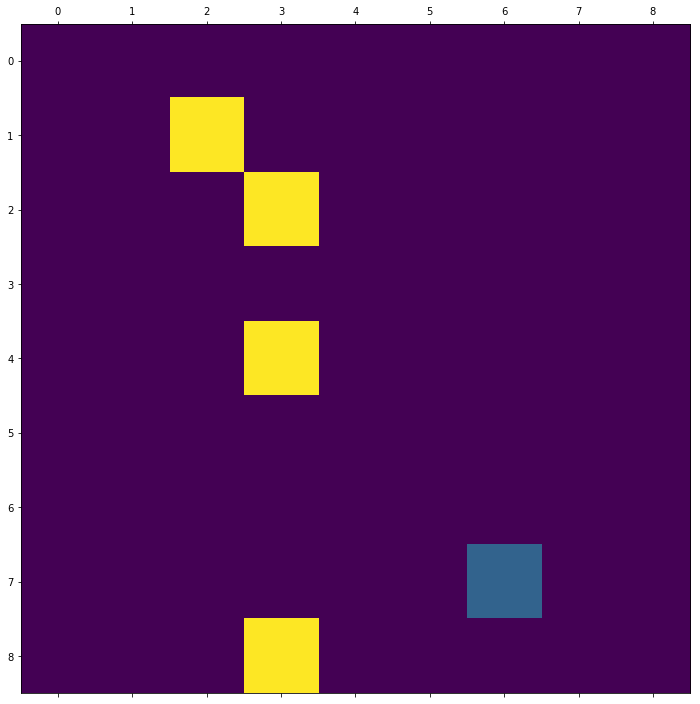

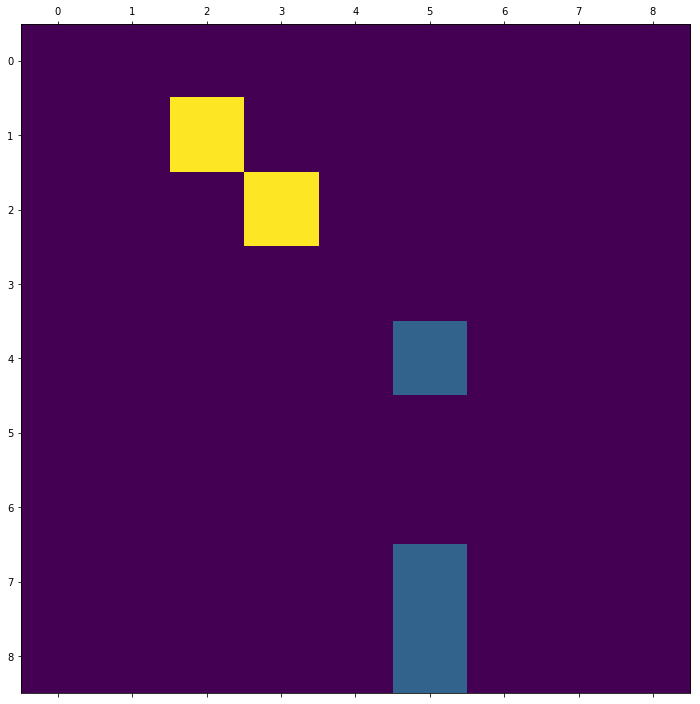

In [93]:
module = 'kripke'
for idx, state in enumerate(states):
    states[state].flow_matrix = create_flow_matrix(states[state], module)
    plt.matshow(state[state].flow_matrix)
#     np.append(np_flow_matrix, state.flow_matrix)
fm = np.array([states['kripke-impi'].flow_matrix, states['kripke-mvapich2'].flow_matrix])

## Plot histogram

In [94]:
def histogram(variable):
    n_bins = 2
    N, bins, patches = plt.hist(variable, bins=n_bins)
    #fracs = N / N.max()
    #norm = colors.Normalize(fracs.min(), fracs.max())
    #for thisfrac, thispatch in zip(fracs, patches):
    #    color = plt.cm.viridis(norm(thisfrac))
    #    thispatch.set_facecolor(color)
    #plt.yaxis.set_major_formatter(PercentFormatter(xmax=1))

## Calculate Spatial distance between each node in the flow matrix

In [95]:
S = len(states)
print(fm)

n_samples = 40
ns = [len(fm[s]) for s in range(S)]

Cs = [sp.spatial.distance.cdist(fm[s], fm[s]) for s in range(S)]
Cs = [cs / cs.max() for cs in Cs]

ps = [ot.unif(ns[s]) for s in range(S)]
p = ot.unif(n_samples)

histogram(ns)

NameError: name 'fm' is not defined

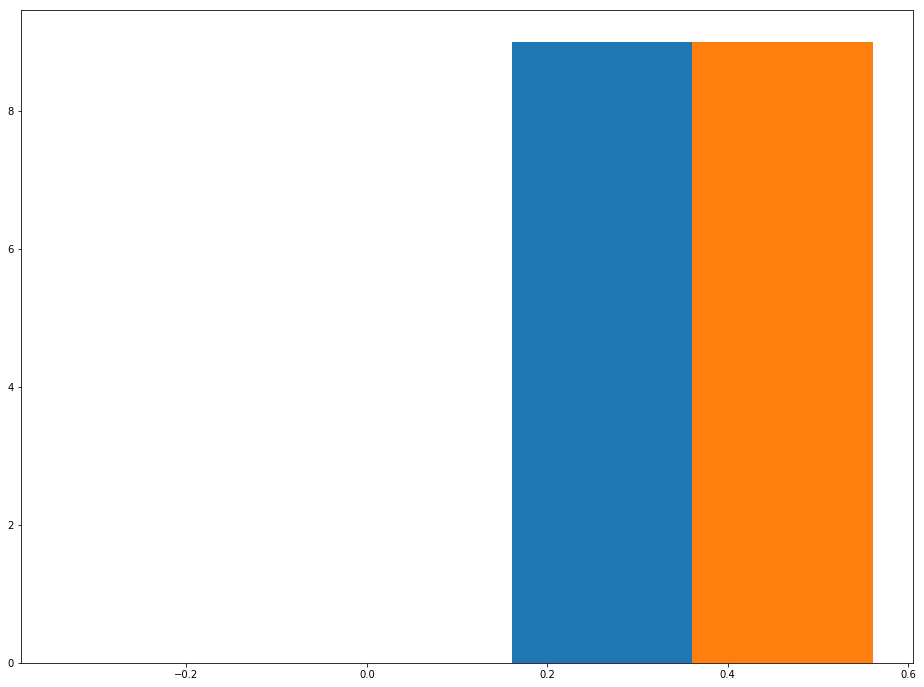

In [107]:
histogram(ps)

## Gromov wassertstein barycenter calculation

By barycenter they mean the design of an “average” or barycenter of similarity matrices.

In [108]:
def plot(variable):
    plt.plot(variable[0], variable[1], 'o', label=str(variable))
    plt.show()

In [96]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensionned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

In [110]:
lambdast = [[float(i) / 3, float(3 - i) / 3] for i in [1, 2]]
Ct01 = [0 for i in range(2)]
for i in range(S):
    Ct01[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[0], Cs[1]],
                                           [ps[0], ps[1]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-9)

In [111]:
clf = PCA(n_components=2)
npos = [0, 0]
npos = [smacof_mds(Cs[s], 2) for s in range(S)]

npost01 = [0, 0]
npost01 = [smacof_mds(Ct01[s], 2) for s in range(2)]
npost01 = [clf.fit_transform(npost01[s]) for s in range(2)] 

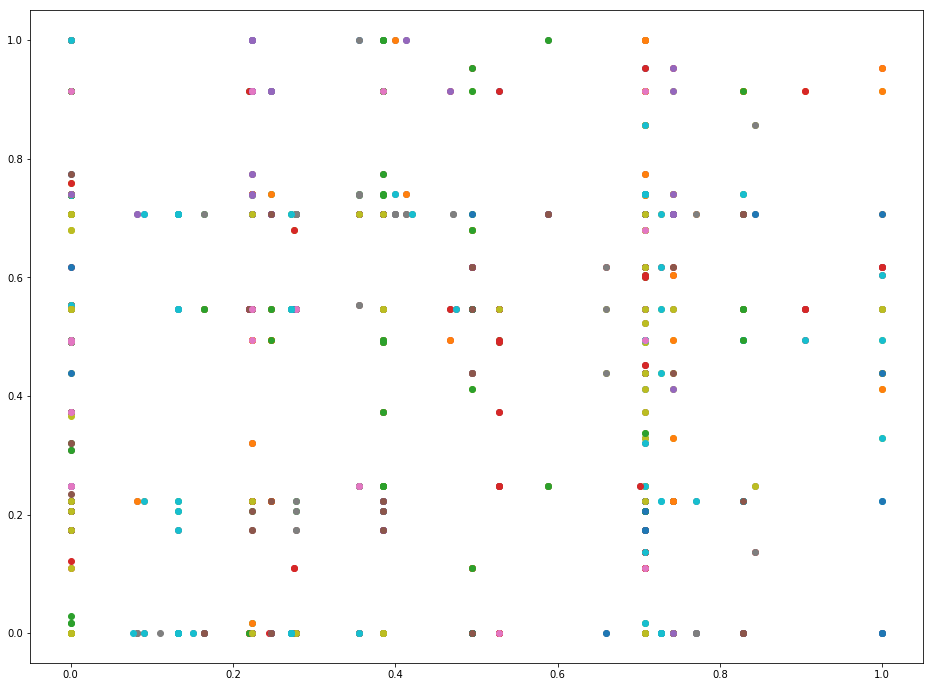

In [112]:
plot(Ct01)

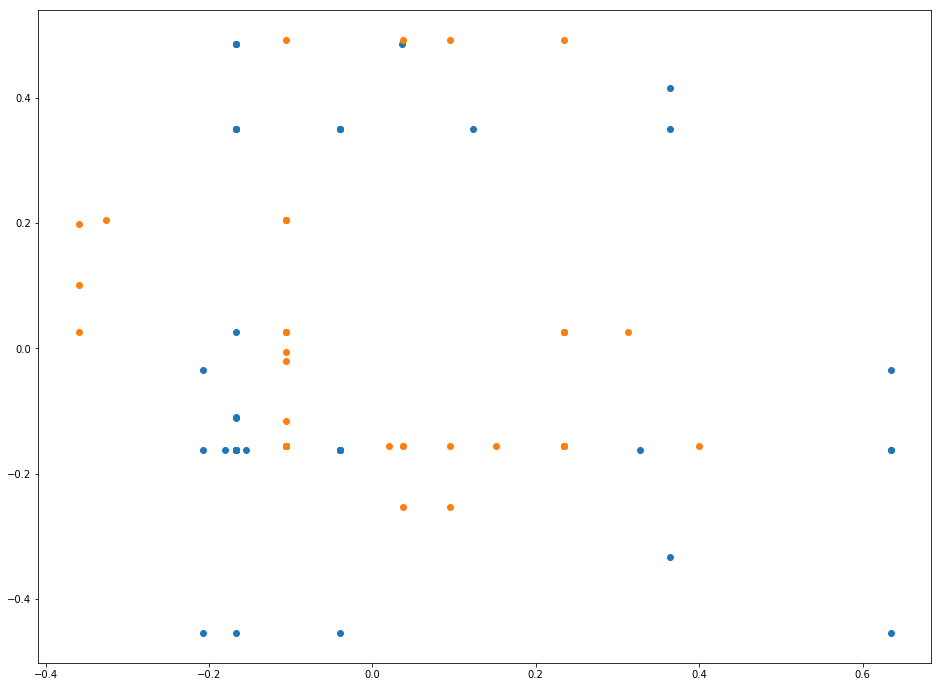

In [113]:
plot(npost01)

40


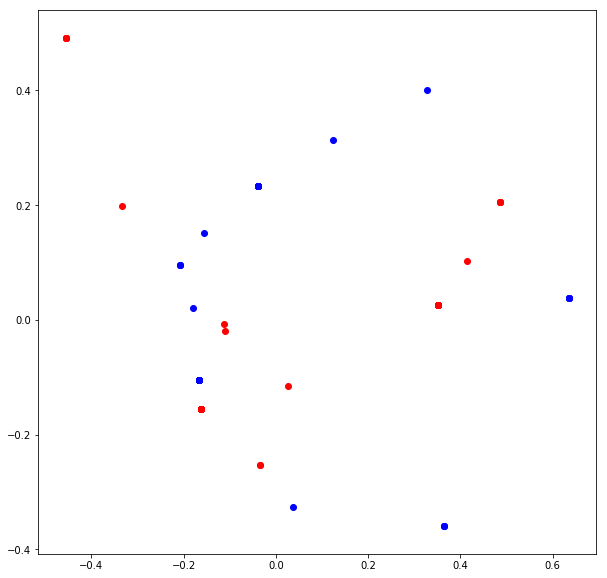

In [114]:
nx01min = npos[0][0][0]
nx01max = npos[0][0][0]
ny01min = npos[0][1][1]
ny01max = npos[0][1][1]

nx02min = npos[1][0][0]
nx02max = npos[1][0][0]
ny02min = npos[1][1][1]
ny02max = npos[1][1][1]

for idx, arr in enumerate(npos):
    if arr[0][0] < nx01min:
        nx01min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx01max:
        nx01max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny01min:
        ny01min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny01max:
        ny01max = arr[1][1]
    else:
        pass


for idx, arr in enumerate(npost01):
    if arr[0][0] < nx02min:
        nx02min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx02max:
        nx02max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny02min:
        ny02min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny02max:
        ny02max = arr[1][1]
    else:
        pass

fig = plt.figure(figsize=(10, 10))

x1 = []
y1 = []
for idx, val in enumerate(npost01[0]):
    x1.append(val[0])
    y1.append(val[1])
    
x2 = []
y2 = []
for idx, val in enumerate(npost01[1]):
    x2.append(val[0])
    y2.append(val[1])

x1 = np.asarray(x1)
x2 = np.asarray(x2)
y1 = np.asarray(y1)
y2 = np.asarray(y2)

print(len(x1))
plt.scatter(x1, y1, color='b')
plt.scatter(x2, y2, color='r')

In [ ]:
def draw_graph(state, module):
    g = state.g
    hierarchy = nx.Graph()
    source_target_data = []
    nodes = [x for x,y in g.nodes(data=True) if y['module'] == [module]]
    node = nodes[0]
    for idx, node in enumerate(nodes):
        hierarchy_pd = pd.DataFrame(columns=['source', 'target', 'weight', 'level', 'type'])
        neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
        for idx, n in enumerate(neighbors):
            #print("source: {0}, target: {1}".format(node, n[0]))
            source_node = node
            target_node = n[0]
            weight = n[1]['weight']
            level = idx
            if(state.df[state.df['name'] == n[0]]['module'].unique()[0] != module):
                type_node = 'exit'
                level = -1
                print('{0} is an exit node'.format(n[0]))
            else:
                type_node = 'normal'
            source_target_data.append({
                "source": source_node,
                "target": target_node,
                "weight": weight,
                "level": level,
                "type": type_node
            })
    hierarchy_df = pd.DataFrame.from_dict(source_target_data)
    print(hierarchy_df.shape)
    hierarchy_adjacency = source_target_to_adj_matrix(source_target_data)
    state.hg = nx.from_numpy_matrix(hierarchy_adjacency)
    pos = hierarchy_pos(state.hg, 1)
    nx.draw(state.hg, pos=pos, with_labels=True)
    plt.show()

draw_graph(states[0], 'lulesh2.0')

In [ ]:
def get_adjcency(nodelist):
    x_pd = nx.to_pandas_adjacency(g, nodelist=nodes, dtype=int)   

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    #if not nx.is_tree(G):
     #   raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
        print(root)
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)